<a href="https://colab.research.google.com/github/bu11ymaguire/studying/blob/main/ReinforcementLearning/montecarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ReinforcementLearning/

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


class Renderer:
    def __init__(self, reward_map, goal_state, wall_state):
        self.reward_map = reward_map
        self.goal_state = goal_state
        self.wall_state = wall_state
        self.ys = len(self.reward_map)
        self.xs = len(self.reward_map[0])

        self.ax = None
        self.fig = None
        self.first_flg = True

    def set_figure(self, figsize=None):
        fig = plt.figure(figsize=figsize)
        self.ax = fig.add_subplot(111)
        ax = self.ax
        ax.clear()
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_xticks(range(self.xs))
        ax.set_yticks(range(self.ys))
        ax.set_xlim(0, self.xs)
        ax.set_ylim(0, self.ys)
        ax.grid(True)

    def render_v(self, v=None, policy=None, print_value=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax

        if v is not None:
            color_list = ['red', 'white', 'green']
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                'colormap_name', color_list)

            # dict -> ndarray
            v_dict = v
            v = np.zeros(self.reward_map.shape)
            for state, value in v_dict.items():
                v[state] = value

            vmax, vmin = v.max(), v.min()
            vmax = max(vmax, abs(vmin))
            vmin = -1 * vmax
            vmax = 1 if vmax < 1 else vmax
            vmin = -1 if vmin > -1 else vmin

            ax.pcolormesh(np.flipud(v), cmap=cmap, vmin=vmin, vmax=vmax)

        for y in range(ys):
            for x in range(xs):
                state = (y, x)
                r = self.reward_map[y, x]
                if r != 0 and r is not None:
                    txt = 'R ' + str(r)
                    if state == self.goal_state:
                        txt = txt + ' (GOAL)'
                    ax.text(x+.1, ys-y-0.9, txt)

                if (v is not None) and state != self.wall_state:
                    if print_value:
                        offsets = [(0.4, -0.15), (-0.15, -0.3)]
                        key = 0
                        if v.shape[0] > 7: key = 1
                        offset = offsets[key]
                        ax.text(x+offset[0], ys-y+offset[1], "{:12.2f}".format(v[y, x]))

                if policy is not None and state != self.wall_state:
                    actions = policy[state]
                    max_actions = [kv[0] for kv in actions.items() if kv[1] == max(actions.values())]

                    arrows = ["↑", "↓", "←", "→"]
                    offsets = [(0, 0.1), (0, -0.1), (-0.1, 0), (0.1, 0)]
                    for action in max_actions:
                        arrow = arrows[action]
                        offset = offsets[action]
                        if state == self.goal_state:
                            continue
                        ax.text(x+0.45+offset[0], ys-y-0.5+offset[1], arrow)

                if state == self.wall_state:
                    ax.add_patch(plt.Rectangle((x,ys-y-1), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
        plt.show()

    def render_q(self, q, show_greedy_policy=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax
        action_space = [0, 1, 2, 3]

        qmax, qmin = max(q.values()), min(q.values())
        qmax = max(qmax, abs(qmin))
        qmin = -1 * qmax
        qmax = 1 if qmax < 1 else qmax
        qmin = -1 if qmin > -1 else qmin


        color_list = ['red', 'white', 'green']
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'colormap_name', color_list)

        for y in range(ys):
            for x in range(xs):
                for action in action_space:
                    state = (y, x)
                    r = self.reward_map[y, x]
                    if r != 0 and r is not None:
                        txt = 'R ' + str(r)
                        if state == self.goal_state:
                            txt = txt + ' (GOAL)'
                        ax.text(x+.05, ys-y-0.95, txt)

                    if state == self.goal_state:
                        continue

                    tx, ty = x, ys-y-1

                    action_map = {
                        0: ((0.5+tx, 0.5+ty), (tx+1, ty+1), (tx, ty+1)),
                        1: ((tx, ty), (tx+1, ty), (tx+0.5, ty+0.5)),
                        2: ((tx, ty), (tx+0.5, ty+0.5), (tx, ty+1)),
                        3: ((0.5+tx, 0.5+ty), (tx+1, ty), (tx+1, ty+1)),
                    }
                    offset_map = {
                        0: (0.1, 0.8),
                        1: (0.1, 0.1),
                        2: (-0.2, 0.4),
                        3: (0.4, 0.4),
                    }
                    if state == self.wall_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
                    elif state in self.goal_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0., 1., 0., 1.)))
                    else:

                        tq = q[(state, action)]
                        color_scale = 0.5 + (tq / qmax) / 2  # normalize: 0.0-1.0

                        poly = plt.Polygon(action_map[action],fc=cmap(color_scale))
                        ax.add_patch(poly)

                        offset= offset_map[action]
                        ax.text(tx+offset[0], ty+offset[1], "{:12.2f}".format(tq))
        plt.show()

        if show_greedy_policy:
            policy = {}
            for y in range(self.ys):
                for x in range(self.xs):
                    state = (y, x)
                    qs = [q[state, action] for action in range(4)]  # action_size
                    max_action = np.argmax(qs)
                    probs = {0:0.0, 1:0.0, 2:0.0, 3:0.0}
                    probs[max_action] = 1
                    policy[state] = probs
            self.render_v(None, policy)

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def argmax(xs):
    idxes = [i for i, x in enumerate(xs) if x == max(xs)]
    if len(idxes) == 1:
        return idxes[0]
    elif len(idxes) == 0:
        return np.random.choice(len(xs))

    selected = np.random.choice(idxes)
    return selected


def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = argmax(qs)  # OR np.argmax(qs)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs


def plot_total_reward(reward_history):
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(range(len(reward_history)), reward_history)
    plt.show()

In [3]:
class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]  # 행동 공간(가능한 행동들)
        self.action_meaning = {  # 행동의 의미
            0: "UP",
            1: "DOWN",
            2: "LEFT",
            3: "RIGHT",
        }

        self.reward_map = np.array(  # 보상 맵(각 좌표의 보상 값)
            [[0, 0, 0, 1.0],
             [0, None, 0, -1.0],
             [0, 0, 0, 0]]
        )
        self.goal_state = (0, 3)    # 목표 상태(좌표)
        self.wall_state = (1, 1)    # 벽 상태(좌표)
        self.start_state = (2, 0)   # 시작 상태(좌표)
        self.agent_state = self.start_state   # 에이전트 초기 상태(좌표)

    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space

    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)

    def next_state(self, state, action):
        # 이동 위치 계산
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        # 이동한 위치가 그리드 월드의 테두리 밖이나 벽인가?
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state:
            next_state = state

        return next_state  # 다음 상태 반환

    def reward(self, state, action, next_state):
        return self.reward_map[next_state]

    def reset(self):
        self.agent_state = self.start_state
        return self.agent_state

    def step(self, action):
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                       self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                        self.wall_state)
        renderer.render_q(q, print_value)

#Monte_Carlo - Sample_Model

In [ ]:
import numpy as np

def sample(dices = 2):
  x = 0
  for _ in range(dices):
    x += np.random.choice([1,2,3,4,5,6])
  return x

In [ ]:
for _ in range(3):
  print(sample())

7
8
8


분포 모델의 경우 일일히 확률 분포를 계산해야되기 때문에 경우의 수가 많아질수록 매우 귀찮아진다. 이에, 샘플링을 많이해서 평균을 구하는 방법이 도입되었고, 이 방법이 몬테카를로 방법이다.

#Implement monte_carlo

In [ ]:
trial = 1000

samples = []

for _ in range(trial):
  s = sample()
  samples.append(s)
  V = sum(samples) / len(samples)
  print(V)

7.0
8.0
7.0
6.75
6.6
7.0
6.714285714285714
7.25
7.333333333333333
7.5
7.090909090909091
7.25
7.615384615384615
7.571428571428571
7.666666666666667
7.3125
7.352941176470588
7.222222222222222
7.368421052631579
7.3
7.190476190476191
7.363636363636363
7.434782608695652
7.458333333333333
7.64
7.6923076923076925
7.592592592592593
7.678571428571429
7.586206896551724
7.6
7.67741935483871
7.78125
7.7272727272727275
7.852941176470588
7.9714285714285715
8.0
8.0
7.973684210526316
7.923076923076923
7.975
8.048780487804878
7.928571428571429
7.953488372093023
7.909090909090909
7.977777777777778
7.891304347826087
7.851063829787234
7.770833333333333
7.6938775510204085
7.62
7.588235294117647
7.653846153846154
7.69811320754717
7.62962962962963
7.618181818181818
7.625
7.684210526315789
7.724137931034483
7.762711864406779
7.666666666666667
7.704918032786885
7.709677419354839
7.634920634920635
7.5625
7.538461538461538
7.5606060606060606
7.582089552238806
7.5588235294117645
7.594202898550725
7.64285714285714

In [ ]:
#증분구현

trial = 1000
V, n = 0, 0

for _ in range(trial):
  s = sample()
  n += 1
  V += (s - V) / n
  print(V)

8.0
6.5
5.333333333333333
6.25
6.0
6.0
5.857142857142857
6.125
6.666666666666667
6.800000000000001
7.090909090909092
7.083333333333334
7.000000000000001
7.214285714285715
7.200000000000001
7.187500000000001
7.352941176470589
7.444444444444445
7.315789473684211
7.05
7.0
6.954545454545454
7.173913043478261
7.041666666666667
7.04
7.153846153846154
7.2592592592592595
7.214285714285714
7.206896551724138
7.1
7.161290322580645
7.1875
7.181818181818182
7.205882352941177
7.228571428571429
7.194444444444445
7.216216216216217
7.236842105263158
7.256410256410257
7.300000000000001
7.414634146341464
7.476190476190476
7.488372093023256
7.5
7.466666666666667
7.478260869565218
7.382978723404256
7.395833333333334
7.387755102040817
7.420000000000001
7.372549019607844
7.403846153846154
7.377358490566038
7.407407407407407
7.454545454545454
7.410714285714286
7.350877192982456
7.431034482758621
7.3559322033898304
7.4
7.409836065573771
7.435483870967742
7.444444444444445
7.421875
7.369230769230769
7.424242424

## 몬테카를로 구현

In [8]:
env = GridWorld()
action = 0
next_state, reward, done = env.step(action)

print(f"next_state: {next_state}")
print(f"reward: {reward}")
print(f"done: {done}")

next_state: (1, 0)
reward: 0
done: False


In [9]:
env = GridWorld()
state = env.reset()

## 에이전트 클래스 구현

In [4]:
from collections import defaultdict

class RandomAgent:
  def __init__(self):
    self.gamma = 0.9
    self.action_size = 4

    random_actions = {0:0.25,1:0.25,2:0.25,3:0.25}
    self.pi = defaultdict(lambda : random_actions) # 정책
    self.V = defaultdict(lambda: 0) # 가치 함수
    self.cnts = defaultdict(lambda: 0) # 증분 방식으로 수익 평균 구하기
    self.memory = []

  def get_action(self, state):
    action_probs = self.pi[state]
    actions = list(action_probs.keys())
    probs = list(action_probs.values())
    return np.random.choice(actions, p = probs)

  def add(self, state, action, reward):
    data = (state, action, reward)
    self.memory.append(data)
#왜 튜플 형태(state, action, reward)로 보관할까? -> memory에서 관리하기 편하도록.

  def reset(self):
    self.memory.clear()

  def eval(self):
    G = 0
    for data in reversed(self.memory):
      state, action, reward = data
      G = self.gamma * G + reward
      self.cnts[state] += 1
      self.V[state] += (G - self.V[state]) / self.cnts[state]

In [13]:
env = GridWorld()
agent = RandomAgent()

episodes = 1000

for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.eval()
            break

        state = next_state

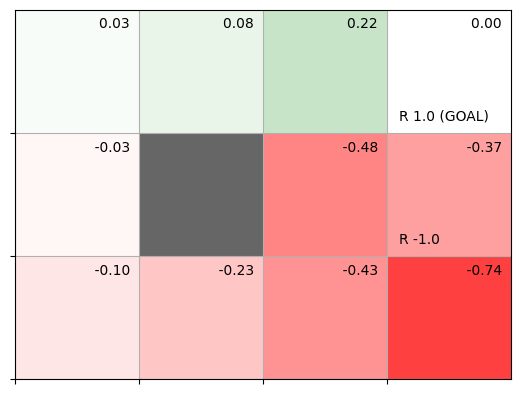

In [14]:
env.render_v(agent.V)

## 몬테카를로법으로 정책 제어 구현

In [21]:
'''
class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0:0.25,1:0.25,2:0.25,3:0.25}
        self.pi = defaultdict(lambda : random_actions)
        self.Q = defaultdict(lambda : 0)
        self.cnts = defaultdict(lambda : 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())

        return np.random.choice(actions, p = probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.cnts[key] += 1

            self.Q[key] += (G - self.Q[key]) / self.cnts[key]

            self.pi[state] = greedy_probs(self.Q, state)
'''           

'\nclass McAgent:\n    def __init__(self):\n        self.gamma = 0.9\n        self.action_size = 4\n\n        random_actions = {0:0.25,1:0.25,2:0.25,3:0.25}\n        self.pi = defaultdict(lambda : random_actions)\n        self.Q = defaultdict(lambda : 0)\n        self.cnts = defaultdict(lambda : 0)\n        self.memory = []\n\n    def get_action(self, state):\n        action_probs = self.pi[state]\n        actions = list(action_probs.keys())\n        probs = list(action_probs.values())\n\n        return np.random.choice(actions, p = probs)\n\n    def add(self, state, action, reward):\n        data = (state, action, reward)\n        self.memory.append(data)\n\n    def reset(self):\n        self.memory.clear()\n\n    def update(self):\n        G = 0\n        for data in reversed(self.memory):\n            state, action, reward = data\n            G = self.gamma * G + reward\n            key = (state, action)\n            self.cnts[key] += 1\n\n            self.Q[key] += (G - self.Q[key])

## 탐욕행동을 취하도록 하는 함수 구현

In [22]:
'''
def greedy_probs(Q, state, action_size= 4):
    qs = [Q[(state,action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    action_probs = {action: 0.0 for action in range(action_size)}

    action_probs[max_action] = 1
    return action_probs
'''

'\ndef greedy_probs(Q, state, action_size= 4):\n    qs = [Q[(state,action)] for action in range(action_size)]\n    max_action = np.argmax(qs)\n\n    action_probs = {action: 0.0 for action in range(action_size)}\n\n    action_probs[max_action] = 1\n    return action_probs\n'

In [5]:
#epsilon - greedy policy
def greedy_probs(Q, state, epsilon = 0, action_size=4):
    qs = [Q[(state,action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

In [9]:
class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1 # epsilon - greedy policy
        self.alpha = 0.1 # Q 함수 갱신 시 고정값
        self.action_size = 4

        random_actions = {0:0.25,1:0.25,2:0.25,3:0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        # self.cnts = defaultdict(lamgda : 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p = probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            # self.cnts[key] += 1
            # self.Q[key] += (G - self.Q[key]) / self.cnts[key]
            self.Q[key] += (G - self.Q[key]) * self.alpha
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)                

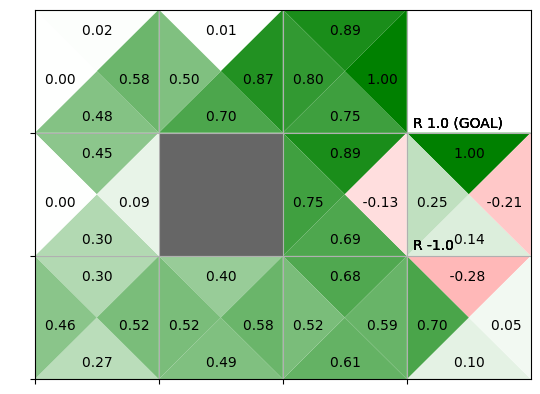

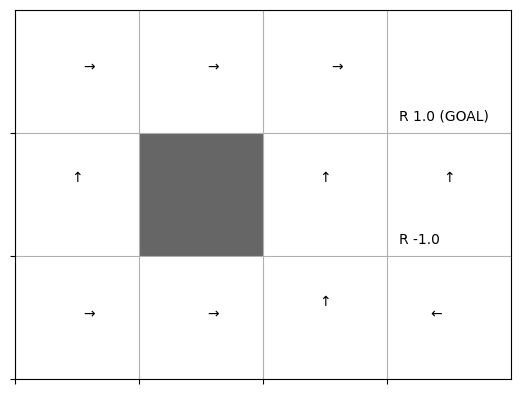

In [12]:
env = GridWorld()
agent = McAgent()

episodes = 10000

for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state


env.render_q(agent.Q)

## 중요도 샘플링

In [3]:
import numpy as np

x = np.array([1,2,3])
pi = np.array([0.1,0.1,0.8])

e = np.sum(x * pi)
print(f"참값:{e}")

n = 100
samples = []
for _ in range(n):
    s = np.random.choice(x, p = pi)
    samples.append(s)

mean = np.mean(samples)
var = np.var(samples)
print(f"몬테카를로법: 평균={mean:.2f}, 분산={var:.2f}")

참값:2.7
몬테카를로법: 평균=2.74, 분산=0.37


In [ ]:
b = np.array([1/3,1/3,1/3])
n = 100
samples = []

for _ in range(n):
    idx = np.arange(len(b))